<a href="https://colab.research.google.com/github/vvamsi91/RTML_AS2/blob/main/RTML_AS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import os
import pickle
import torchvision

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Alex_Network(nn.Module):
    def __init__(self, use_dropout=False):
        super(Alex_Network, self).__init__()
        self.use_dropout = use_dropout

        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(48, 120, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(120, 186, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(186, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
          x = self.features(x)
          x = x.view(-1, 128 * 4 * 4)
          x = self.classifier(x)
          return x

# Transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading and loading CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
torch.manual_seed(123)

In [10]:
cifar10 = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))


Files already downloaded and verified


In [11]:
cifar10_val = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))


Files already downloaded and verified


In [12]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean, std = imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)

Files already downloaded and verified


In [13]:

train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

epoch -  0  Train Loss -  [1.6588251851951932]  Train Accuracy -  [36.736]  Validation Loss -  [1.3745698599388805]  Validation Accuracy -  [49.1]
epoch -  1  Train Loss -  [1.6588251851951932, 1.2527502695490593]  Train Accuracy -  [36.736, 54.852]  Validation Loss -  [1.3745698599388805, 1.1671090819203436]  Validation Accuracy -  [49.1, 58.51]
epoch -  2  Train Loss -  [1.6588251851951932, 1.2527502695490593, 1.0451508321711747]  Train Accuracy -  [36.736, 54.852, 63.08]  Validation Loss -  [1.3745698599388805, 1.1671090819203436, 1.0462254253439247]  Validation Accuracy -  [49.1, 58.51, 63.24]
epoch -  3  Train Loss -  [1.6588251851951932, 1.2527502695490593, 1.0451508321711747, 0.9069558421694462]  Train Accuracy -  [36.736, 54.852, 63.08, 68.008]  Validation Loss -  [1.3745698599388805, 1.1671090819203436, 1.0462254253439247, 0.9791177443612498]  Validation Accuracy -  [49.1, 58.51, 63.24, 66.23]
epoch -  4  Train Loss -  [1.6588251851951932, 1.2527502695490593, 1.045150832171174

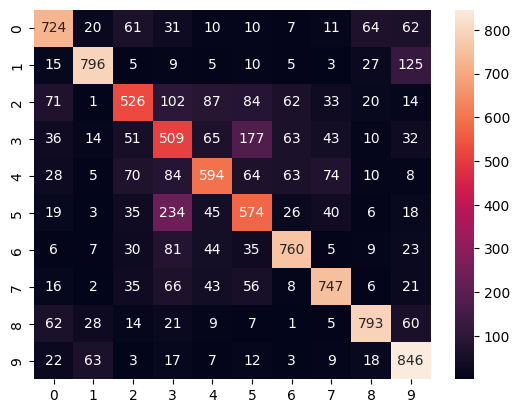

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = Alex_Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(test_loader))
    val_accuracy.append(100 * correct / total)
    print("epoch - ", epoch, " Train Loss - ", train_loss, " Train Accuracy - ", train_accuracy, " Validation Loss - ", val_loss, " Validation Accuracy - ", val_accuracy)

# Evaluate the model
y_pred, y_true = [], []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')


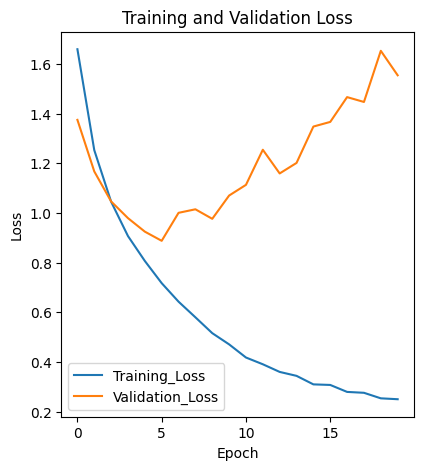

In [17]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training_Loss')
plt.plot(val_loss, label='Validation_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
class Alex_Network(nn.Module):
    def __init__(self, use_dropout=False):
        super(Alex_Network, self).__init__()
        self.use_dropout = use_dropout

        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(48, 120, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(120, 186, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(186, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
          x = self.features(x)
          x = x.view(-1, 128 * 4 * 4)
          x = self.classifier(x)
          return x

# Transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading and loading CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the network
model = Alex_Network(use_dropout=True)

# Check if GPU is available and move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Files already downloaded and verified
Files already downloaded and verified


epoch -  0  Train Loss -  [1.6972401508214148]  Train Accuracy -  [36.22]  Validation Loss -  [1.4152797609091567]  Validation Accuracy -  [48.02]
epoch -  1  Train Loss -  [1.6972401508214148, 1.3895077435007785]  Train Accuracy -  [36.22, 49.228]  Validation Loss -  [1.4152797609091567, 1.2749938368797302]  Validation Accuracy -  [48.02, 53.25]
epoch -  2  Train Loss -  [1.6972401508214148, 1.3895077435007785, 1.278449409143786]  Train Accuracy -  [36.22, 49.228, 53.946]  Validation Loss -  [1.4152797609091567, 1.2749938368797302, 1.2012336922529787]  Validation Accuracy -  [48.02, 53.25, 55.98]
epoch -  3  Train Loss -  [1.6972401508214148, 1.3895077435007785, 1.278449409143786, 1.2032265078540956]  Train Accuracy -  [36.22, 49.228, 53.946, 56.908]  Validation Loss -  [1.4152797609091567, 1.2749938368797302, 1.2012336922529787, 1.1212698733463835]  Validation Accuracy -  [48.02, 53.25, 55.98, 60.21]
epoch -  4  Train Loss -  [1.6972401508214148, 1.3895077435007785, 1.278449409143786

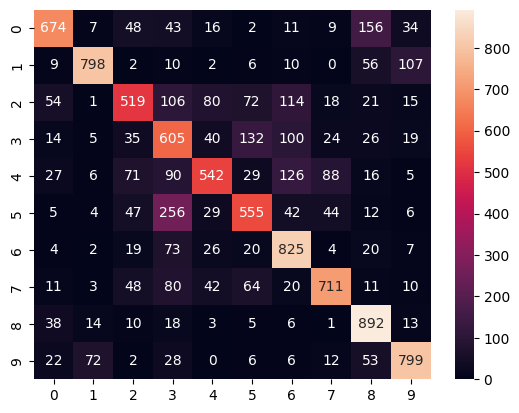

In [25]:

# Training loop
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(test_loader))
    val_accuracy.append(100 * correct / total)
    print("epoch - ", epoch, " Train Loss - ", train_loss, " Train Accuracy - ", train_accuracy, " Validation Loss - ", val_loss, " Validation Accuracy - ", val_accuracy)

# Evaluate the model
y_pred, y_true = [], []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')


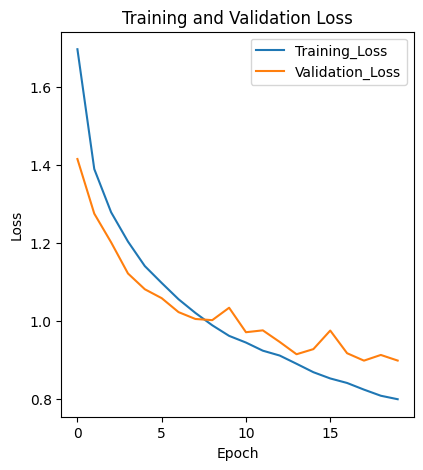

In [26]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training_Loss')
plt.plot(val_loss, label='Validation_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
#Problem 2

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

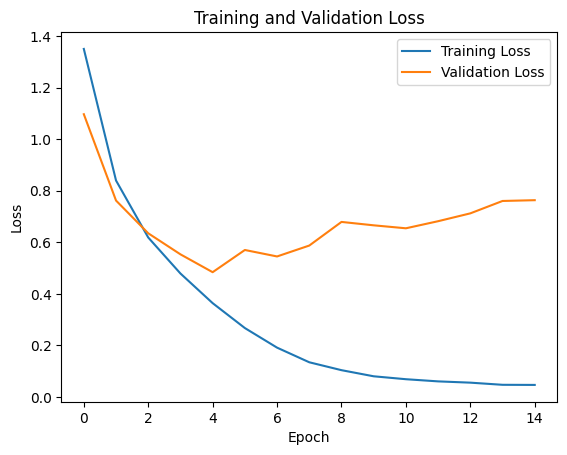

In [29]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional module for activation functions and more
import torch.optim as optim
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out

#ResNet11:have 11 layers in total, including convolutional and fully connected layers.
#it could have 4 residual blocks with a varying number of convolutional layers in each block to make up a total of 11 layers.

# Example of using the ResNet11 model
model = ResNet11(BasicBlock, num_classes=10)  # 4 blocks with 1 layer each
print(model)


# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

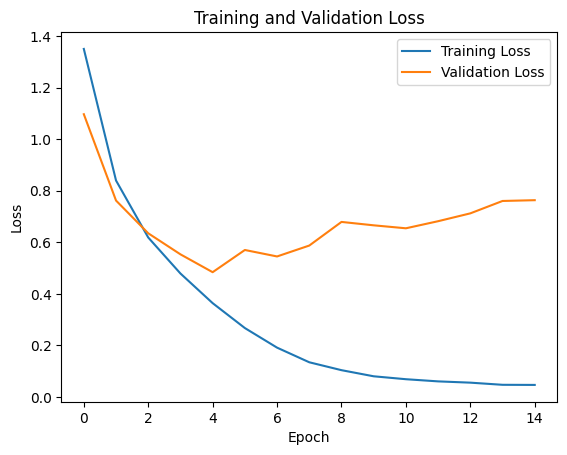

In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional module for activation functions and more
import torch.optim as optim
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out

#ResNet11:have 11 layers in total, including convolutional and fully connected layers.
#it could have 4 residual blocks with a varying number of convolutional layers in each block to make up a total of 11 layers.

# Example of using the ResNet11 model
model = ResNet11(BasicBlock, num_classes=10)  # 4 blocks with 1 layer each
print(model)


# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [32]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.dropout(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_classes=10, dropout_prob=0.5):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, 2, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, 2, stride=2, dropout_prob=dropout_prob)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_prob):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, dropout_prob=dropout_prob))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

# Example of using the updated ResNet11 model with dropout
model = ResNet11(BasicBlock, num_classes=10, dropout_prob=0.5)
print(model)

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training loss: 1.6749704140009058, Validation loss: 1.2805843796973793, Validation Accuracy: 51.91%
Epoch 2, Training loss: 1.280474747287411, Validation loss: 1.1634000467416197, Validation Accuracy: 58.6%
Epoch 3, Training loss: 1.1026714525768868, Validation loss: 0.8923868738805143, Validation Accuracy: 68.45%
Epoch 4, Training loss: 0.9780867432297153, Validation loss: 0.8707736538241084, Validation Accuracy: 69.45%
Epoch 5, Training loss: 0.8755512667709029, Validation loss: 0.7638064218214906, Validation Accuracy: 73.76%
Epoch 6, Training loss: 0.8022555445183261, Validation loss: 0.706006995405252, Validation Accuracy: 75.65%
Epoch 7, Training loss: 0.737725564820295, Validation loss: 0.6725344889746687, Validation Accuracy: 76.17%
Epoch 8, Training loss: 0.682757094254573, Validation loss: 0.6014346105698198, Validation Accuracy: 79.66%
Epoch 9, Training loss: 0.6272605459

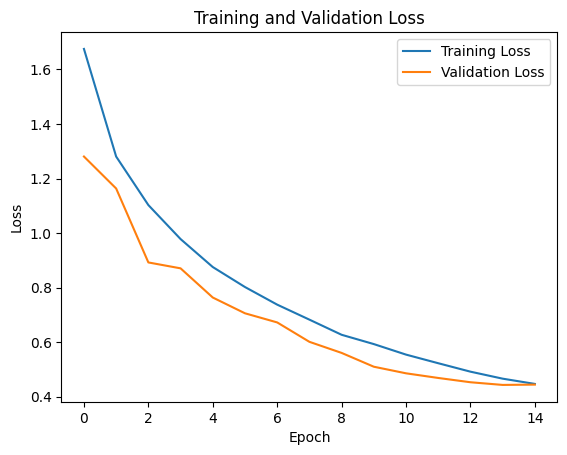

In [33]:

# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()